In [ ]:
!pip install -q scikit-learn==1.0.1

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, brier_score_loss, cohen_kappa_score, make_scorer
import itertools
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
import random
from typing import Dict, List

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Receiver operating characteristic (ROC)

### Intuition

Mathematically, ROC graphs are two dimensional graphs in which the x-axis is the False Positive Rate (FPR) and the y-axis, the True Positive Rate (TPR). The curve is parametrized by the parameter $\vec{thr}$ which represents the threshold of the classifier. The graph also depicts the tradeoffs between TPR and FPR, much like the dilemma of the Bias-Variance tradeoff. Also note that in the ROC space, each point on the graph represents a threshold, and therefore each point can have its own confusion matrix as well.

We come up with an example from the [Melanoma Competition](https://www.kaggle.com/c/siim-isic-melanoma-classification) where we denote a malignant cell to be 1, and benign to be 0. If we treat the **malignance class as positive class**, and the model you trained on outputs a probability vector (using softmax here) $[0.7, 0.3]$ corresponding to class 0 and 1 respectively, the value of 0.3 translates to saying that the image is 30% positive that it is malignant; in other words, it is 70% sure that this image is a benign cell. If we choose the default threshold to be the traditional $\vec{thr}=0.5$, then the classifier will label this image as a $0$. This is because the thresholds defines our **hard label** from the **soft label**, and thus anything above the threshold 0.5, will be classified as a positive class 1, and negative class otherwise.

If however, you lower your classification threshold, say from 0.5 to 0.2, then our image will become now become positive class, indicating the image's cell to be malignant. Intuitively, the consequence is that more images will be classified to become positive as lowering the threshold will allow the model to predict true more often. The consequence is that the TPR will go up, and so will the FPR.

---

<div class="alert alert-block alert-warning">
<b>Example:</b> There are 10 ground truth targets of y_true = [1,1,1,0,0,0,0,0,1,0,0] and your model predicts y_pred = [0.6,0.7,0.4,0.6,0.55,0.4,0.3,0.2,0.6,0.1] which if you apply argmax to y_pred, then it will become y_pred_argmax = [1,1,0,1,1,0,0,0,1,0]. The TPR here is given by $\frac{2}{4}$ since there are 4 positive ground truth, and among the predicted labels, the model correctly classify 2 positives correctly. The FPR is given by $\frac{3}{6}$ because we gave 3 people the false alarm, predicting them to have cancer whereas they don't. Now if you lower you threshold to 0.2, then you can see that the new predicted label array to be [1,1,1,1,1,1,1,0,1,0] where the new calibrated TPR is $\frac{3}{4}$ and the FPR is $\frac{5}{6}$. Therefore, without any proofs, just intuition, one should be convinced that if you lower the threshold, more patients will be classified as positive, consequently, the TPR and FPR both increase. Conversely, if you increase the threshold, then the TPR and FPR will both decrease. This may not hold true in a monotone manner, as wrongly described earlier, as it can jolly well be the TPR or FPR do not change, as can be seen in the diagram in the section Ranking.
</div>   



### Definition of ROC Curve

<div class="alert alert-block alert-success">
<b>Definition:</b> The ROC Curve is a graph that plots the True Positive Rate on the y-axis and False Positive Rate on the x-axis, furthermore, this curve is parametrized by a threshold vector $\vec{t}$.
</div>

---

> From Wikipedia: In binary classification, the class prediction for each instance is often made based on a continuous random variable $X$, which is a "score" computed for the instance (e.g. the estimated probability in logistic regression). Given a threshold parameter $T$, the instance is classified as "positive" if $X > T$, and "negative" otherwise. $X$ follows a probability density $f_1(x)$ if the instance actually belongs to class "positive", and $f_0(x)$ if otherwise. Therefore, the true positive rate is given by $TPR(T) = \int_{T}^{\infty}f_1(x)dx$ and the false positive rate is given by $FPR(T) = \int_{T}^{\infty}f_0(x)dx$. The ROC curve plots parametrically TPR(T) with FPR(T) as the varying parameter.

<div class="alert alert-block alert-warning">
<b>Example:</b> 
For example, imagine that the blood protein levels in diseased people and healthy people are normally distributed with means of 2 g/dL and 1 g/dL respectively. A medical test might measure the level of a certain protein in a blood sample and classify any number above a certain threshold as indicating disease. The experimenter can adjust the threshold (black vertical line in the figure), which will in turn change the false positive rate. Increasing the threshold would result in fewer false positives (and more false negatives), corresponding to a leftward movement on the curve. The actual shape of the curve is determined by how much overlap the two distributions have.
</div>   


### Definition of Area under ROC Curve

<div class="alert alert-block alert-success">
<b>Definition:</b> The AUROC is thus the area under the ROC Curve.
</div>

More formally, in the [probabilistic perspective of AUC](https://www.alexejgossmann.com/auc/), AUC is the probability of a randomly chosen positive case outranks a randomly chosen negative case based on the classifier.

$$
\begin{aligned}
AUC &= P(f(x+)>f(x−)|\text{class}(x+)=1, \text{class}(x−)=0)\\ 
	&= \frac{1}{PN}\sum_{i=1}^{P}\sum_{j=1}^{N}1(f(x+)−f(x−))
\end{aligned}
$$

where 

- $f(x)$: classifier
- P : # of true positive item,
- N : # of true negative item

---

Or expressed in another digestable way:

> The AUC of a classifier is equal to the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example, i.e. $P\Big(\text{score}(x^+) > \text{score}(x^-)\Big)$

> This line above means that if you randomly take two samples, one positive and one negative, the AUC score, say 0.8, says that the probability of your positive sample being ranked higher (means probability higher) than the negative sample is 0.8.

In other words, it measures how well the probability ranks based on their true classes. Thus, it is a threshold-invariant and scale-invariant metrics and only the sequence matters in the predicted probabilities. Based on this property, models with higher AUC indicate better discrimination between the two classes. However, the probabilities output from models with higher AUC don’t always generate well-calibrated probabilities. More information can be found here: [Safe Handling Instructions for Probabilistic Classification](https://www.youtube.com/watch?v=RXMu96RJj_s).

---

Another answer from Stackoverflow, to reference it.

Although I'm a bit late to the party, but here's my 5 cents. @FranckDernoncourt (+1) already mentioned possible interpretations of AUC ROC, and my favorite one is the first on his list (I use different wording, but it's the same):

> the AUC of a classifier is equal to the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example, i.e. $P\Big(\text{score}(x^+) > \text{score}(x^-)\Big)$



Consider this example (auc=0.68): 

![enter image description here][1]

Let's try to simulate it: draw random positive and negative examples and then calculate the proportion of cases when positives have greater score than negatives

<!-- language: lang-r -->

	cls = c('P', 'P', 'N', 'P', 'P', 'P', 'N', 'N', 'P', 'N', 'P',
	        'N', 'P', 'N', 'N', 'N', 'P', 'N', 'P', 'N')
	score = c(0.9, 0.8, 0.7, 0.6, 0.55, 0.51, 0.49, 0.43, 0.42, 0.39, 0.33, 
	          0.31, 0.23, 0.22, 0.19, 0.15, 0.12, 0.11, 0.04, 0.01)

	pos = score[cls == 'P']
	neg = score[cls == 'N']

	set.seed(14)
	p = replicate(50000, sample(pos, size=1) > sample(neg, size=1))
	mean(p)

And we get 0.67926. Quite close, isn't it? 

&nbsp;

By the way, in R I typically use [ROCR][2] package for drawing ROC curves and calculating AUC. 

<!-- language: lang-r -->

	library('ROCR')

	pred = prediction(score, cls)
	roc = performance(pred, "tpr", "fpr")

	plot(roc, lwd=2, colorize=TRUE)
	lines(x=c(0, 1), y=c(0, 1), col="black", lwd=1)

	auc = performance(pred, "auc")
	auc = unlist(auc@y.values)
	auc

![enter image description here][3]


  [1]: http://i.stack.imgur.com/QY5BJ.png
  [2]: https://rocr.bioinf.mpi-sb.mpg.de/
  [3]: http://i.stack.imgur.com/Zw4Yw.png

### AUROC as a Ranking 

One confusing aspect of ROC space is the ranking system. This can be seen in the notebook I created here. Remember, if you code it out yourself from scratch, then it will be more beneficial as you can understand where ranking come into play (without using sklearn). The algorithm starts from the point where threshold is \infty or in sklearn it starts with some other number. A threshold of infinity will guarantee that the point starts at (0,0). Thus, our very first point MUST start from the origin in this algorithm. Then assuming we do not consider an infinity number of thresholds, as this is too computationally expensive, we consider say 10 threshold values that we want to test (a common number is the number in the dataset). We divide the 10 values into 0.9,0.8,0.7,...,0.1, (for example only). Then we start from 0.9, the highest threshold, and move down to the lowest, in order (ranking). As we have seen just now, as you lower the threshold, both your TPR and FPR go up. Therefore, if you don't want to get your hands dirty, then the intuition is that if you have ground truth [0,1,1,0] and pred_1 = [0.03,0.99,0.05,0.06] and pred_2 = [0.15,0.92,0.89,0.91] then if you then imagine that your thresholds are given by thres_1 = [infinity,0.99,0.06,0.05,0.03] and thres_2 = [infinity, 0.92,0.91,0.89,0.15] , then you can calculate that the TPR and FPR rate at each of the threshold for both predictions are actually the same, consequently, forming the same ROC curve. (Consider plotting it). The idea here is we do not care what your values of the predictions are, in fact, in neural networks, transforming logits through softmax may not be a well calibrated (refer to my calibrated probability notes) probability anyways. We do however, care about the ranking, as you can see our thresholds are sorted in descending order, noticed that we only need that many thresholds for the dataset because only the thresholds at the predictions matter. If you take a number between 0.06 and 0.99 for the first threshold set, you will notice that between this threshold, the TPR and FPR will always be the same. Therefore, we conclude, without proof, that if two arrays of prediction has the exact same relative order, then the AUC for both predictions will be the same, which means that AUC is invariant to the scale of the predictions, and in fact invariant to any sort of transformation, that preserves the order (i.e. a non-negative linear transformation); (you can have numbers greater than 1 and the AUC will be the same try [100,200,150,160]).  A corollary of this is we can’t treat outputs of an AUC-optimized model as the likelihood that it’s true. Some models may be poorly calibrated (eg: its output is always between 0.3 and 0.32) but still achieve a good AUC score because its relative ordering is correct. This is something to look out for when blending together predictions of different models.


<img src='https://raw.githubusercontent.com/reigHns/reighns-MLAlgorithms/master/reighns-metrics/data/images/ranking_auc.png' width="390" height="200"/>

Furthermore, if you see my notebook example, you can predict wrongly, but still have an AUC of 1. One last thing is about the predictions ordering, there is no rule that your predictions must SORT IN DESCENDING ORDER, for example: This will give you an AUC score of 1, even though it may not seem to predict everything correctly. Because the below order gives rise to the best AUC, which is 1 in this case, and hence this will give you 1 as well. If you switch a few numbers inside y_pred you will notice it can still stay at 1. However, if you reverse the list order, then you will get an AUC of 0 (the opposite of the best).

```python
y_true = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
y_pred = [0.99999, 0.98, 0.97, 0.96, 0.95, 0.94, 0.68139, 0.50961, 0.48880, 0.44951]
full_score_example = sklearn.metrics.roc_auc_score(y_true, y_pred)  
print(full_score_example) -> 1
```

In [ ]:
y_true = [1, 0, 1, 1, 0]
y_pred = [0.5, 0.25, 0.2, 0.3, 0.1]
y_pred_same_rank = [100, 25, 20, 30, 10]


fpr_rank_1, tpr_rank_1, threshold_rank_1 = sklearn.metrics.roc_curve(y_true, y_pred, drop_intermediate=True)
fpr_rank_2, tpr_rank_2, threshold_rank_2 = sklearn.metrics.roc_curve(y_true, y_pred_same_rank, drop_intermediate=True)
roc_rank_1 = sklearn.metrics.roc_auc_score(y_true=y_true, y_score=y_pred, average="macro", sample_weight=None, max_fpr=None)  # 0.833
roc_rank_2 = sklearn.metrics.roc_auc_score(y_true=y_true, y_score=y_pred_same_rank, average="macro", sample_weight=None, max_fpr=None)  # 0.833

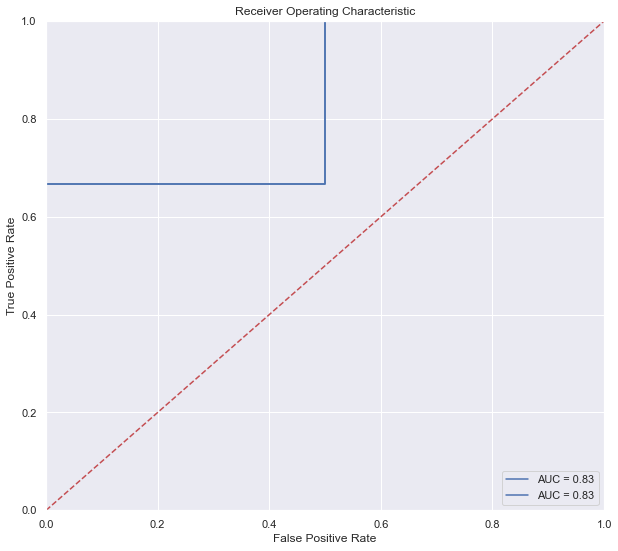

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize =[10,9])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rank_1, tpr_rank_1, 'b', label = 'AUC = %0.2f' % roc_rank_1)
plt.plot(fpr_rank_2, tpr_rank_2, 'b', label = 'AUC = %0.2f' % roc_rank_2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

### ROC as C-Statistic

ROC can be interpreted as [c-statistics](https://stats.stackexchange.com/questions/193138/roc-curve-drawbacks).
ROC AUC has the property that it coincides with the $c$ statistic. The $c$ statistic measures the probability that a positive example is ranked higher than a negative example. In this sense, the ROC AUC answers the question of how well the model discriminates between the two classes.

A model with high discrimination is not necessarily well calibrated. Suppose a logistic regression model predicts probabilities of 0.52 for positives and 0.51 for negatives (imagine 10 ground truth where 6 is positive and 4 is negative, then the author meant the associated probabilities with each of these ground truth is 0.52 and 0.51 respectively, for the positive and negative classes). This model has an AUC of 1 (recall you need not predict everything correctly to get an AUC of 1) but the probabilities aren't helpful in the sense of identifying which purported positives are highest-risk. Because all of the positives are assigned the same posterior probability, they can't be differentiated.

Moreover, a well-calibrated model will have its maximum ROC AUC fixed by the ratio of positives to negatives in the data. This means that a model which has some very desirable probabilities (i.e. its posterior probabilities match the true probability) has a cap on its performance, and therefore an **uncalibrated** model could "dominate" in terms of ROC AUC.

ROC AUC doesn't tell you anything about the costs of different kinds of errors. For example, if you're trying to detect fraud, a 10,000 dollar purchase of uncertain provenance represents a larger potential loss than a 10 dollar purchase. But ROC AUC would treat both events as if they have the same weight -- obviously any reasonable model should be able to distinguish between these two types of error.

ROC AUC also tends to be dominated by the "high FPR" points. **Depending on the application, these points may be the least relevant.** Consider the case where the model is used to refer high-risk transactions to experts who will conduct further vetting. There may only be enough humans to assess 50 transactions per unit time; since the most highly-ranked transactions occur on the "left hand" size of the ROC curve by definition, this is also the region with the lowest area. So by looking at the whole AUC, you're optimistically biasing your results upwards, i.e. ROC AUC is buoyed by the observations "to the right" of the actual set of observations which humans will vet. (Illustration is simple. Draw a vertical line at FPR<0.5 on any ROC curve. The area to left is higher for all such vertical lines.) To avoid this, some people use partial ROC AUC, which has its own host of problems, chief among them that software implementations tend to assume that you're interested in truncation *at some value of FPR.* But in the case that you care about the top $n$ transactions, this approach is obviously wrong because the top $n$ transactions will happen at different FPR values for different classifiers. Standardization of partial AUC (to preserve the property that AUC < 0.5 is worse than random, 1 is perfect, 0 is worthless) incurs further difficulties.

The ROC curve itself is of little interest. "Dominating" classifiers can be assessed by AUC. Stochastic equivalence can be assessed by tests of equivalence of ranks. Prof. Harrell's comment drives at a consistent theme of his work, which is that the real question diagnostics should answer is one of risk assessment and utility optimization. Examining ROC AUC tends to encourage selection of truncation points, which should be avoided because it only provides partial information to decision makers.

Alternative measures of performance (e.g. log-likelihood) characterize the calibration of the model and proper scoring rules generally have the quality that they encourage honest forecasts.

### Pros and Cons of AUROC

Before we go ham on the [Drawbacks of AUROC](https://stats.stackexchange.com/questions/193138/roc-curve-drawbacks), we first try to think the following:

<div class="alert alert-block alert-info">
<b>Food For Thought:</b> I think intuitively you can say that if your model needs to perform equally well on the positive class as the negative class (for example, for classifying images between cats and dogs, you would like the model to perform well on the cats as well as on the dogs. For this you would use the AUROC.)<p>

On the other hand, if you're not really interested in how the model performs on the negative class, but just want to make sure every positive prediction is correct (precision), and that you get as many of the positives predicted as positives as possible (recall), then you should choose PRAUC (more with it later). For example, for detecting cancer, you don't care how many of the negative predictions are correct, you want to make sure all the positive predictions are correct, and that you don't miss any. (In fact, in this case missing a cancer would be worse than a false positive so you'd want to put more weight towards recall.)
</div>

#### Pros: When your classes are more balanced



ROC curves are insensitive to changes in class distribution. Quote unquote from "The analysis of ROC Curves", we see that the **if the proportion of positive to negative instances changes in a test set, the ROC curves will not change**. This is because the AUC is equals to the probability of ranking a random positive example over a random negative example, and by definition this happens after you have drawn a positive and a negative, which indicates that we do not need to know anything about the original distribution and the class proportions.

---

AUROC curve better reflects the total amount of False Positives independent of in which class they come up. We can see this by a simple math example:

Essentially, AUROC is measuring the TPR vs FPR ratio: We can interpret it as such

$$TPR:FPR = \dfrac{TP}{TP + FN} : \dfrac{FP}{FP+TN} = \dfrac{TP}{TP+FN} \times \dfrac{FP + TN}{FP} = \dfrac{TP}{|+|} \times \dfrac{|-|}{FP}=\dfrac{|-|}{|+|} \times \dfrac{TP}{FP}$$



---

<!-- This portion here is important and can be extended into the Cons section as well. In summary, if you notice that AUROC curve is made up by TPR vs FPR, and since FPR = 1- TNR, we can deduce the following:

$$FPR = 1 - P(\hat{Y}=0|Y=0) \text{ and } TPR = P(\hat{Y}=1|Y=1)$$

Now you may wonder, why did I express them in this format? This is because we should understand it probabilistically. Notice that both TPR and FPR are **probabilities conditioned on the true class label**. As a result, AUROC curves is the same no matter what the baseline probability is. To make it more concrete, consider the sample set $\mathcal{D}$ to have 100 samples, in which 90 is **negative** and 10 is **positive**. Thus the baseline classifier ZeroR will always predict majority, in this case, it will always predict negative.

$$P(Y=1) = 10\% \text{ and } P(Y=0) = 90\%$$ -->

#### Pros: Scale Invariant

**See section on AUROC as a Ranking for code example**. 

AUC measures how well predictions are ranked, rather than their absolute values. **This means that your score from the model need not be calibrated into a strict probability. You can predict any score you want. This allows us to compare different classifiers that predict values on a different scale.**

---

This can be a con as highlighted in Cons: uncalibrated.

#### Pros: Classification Threshold Invariant

AUC measures the quality of the model's predictions irrespective of what classification threshold is chosen. What this means is if you compare an example to accuracy, how do you compute it? You say that if threshold is more than $t$, then you proceed to calculate the accuracy score - and different threshold gives different accuracies. But in ROC, the nuance is that our final metric is area under the ROC curve, over various (all possible) thresholds $t$, so as you see, we do not depend on the threshold to calculate the final score! This may be good in the sense that it gives you an overall performance on the binary classifier.

---

This can also be a con when you want to specifically minimize one metric like False Negatives or False Positives. For example, in cancer detection where malignant is the positive class, you will likely want to minimize False Negatives, **even if it results in a huge increase in False Positives**, then ROC may not be best suited. So if you only have the ROC curve for analysis, then you can choose your threshold according to the curve, in this case we choose the point which maximizes TPR as maximizing TPR is equivalent to minimizng FN.

#### Cons: Imbalanced

<div class="alert alert-block alert-danger">
<b>Imbalanced Data:</b> We examine the case in which the dataset is imbalanced and further assume that the positive class is the minority, (note if you assume positive class is majority, then ROC may perform very well here, so the assumption is that the minority is of the positive class). We assume further that the negative class is 90% and positive class is 10%. Intuitively, in an imbalanced dataset, the model **usually does not have trouble predicting the majority class**, and this suggests that they will often get the negatives correct in this case, leading to a high TN. By looking at the FPR, we notice that $\frac{FP}{FP + TN}$ suggests that FP will be low and TN will be high simply because of the aforementioned idea that the model will likely get the TN correct, and if TN is high, then the FP is low. Consequently, FPR is high. <p>

The following [on why AUC can be misleading](https://stats.stackexchange.com/questions/360017/when-is-an-auc-score-misleadingly-high/360040#360040)
One possible reason you can get high AUROC with what some might consider a mediocre prediction is if you have imbalanced data (in favor of the "zero" prediction), high recall, and low precision. That is, you're predicting most of the ones at the higher end of your prediction probabilities, but most of the outcomes at the higher end of your prediction probabilities are still zero. This is because the ROC score still gets most of its "lift" at the early part of the plot, i.e., for only a small fraction of the zero-predictions. 

For example, if 5% of the test set are "ones" and all of the ones appear in the top 10% of your predictions, then your AUC will be at least 18/19 because, after 18/19 of the zeroes are predicted, already 100% of the ones were predicted. Even if the top 5% are all zeroes.

Whether this is a "bad" prediction depends on your priorities. If you think that false negatives are terrible and false positives are tolerable, then this prediction is okay. But if it's the opposite, then this prediction is pretty bad.
</div>

[0.9        0.87333333 0.84666667 0.82       0.79333333 0.76666667
 0.74       0.71333333 0.68666667 0.66       0.63333333 0.60666667
 0.58       0.55333333 0.52666667 0.5        0.47333333 0.44666667
 0.42       0.39333333 0.36666667 0.34       0.31333333 0.28666667
 0.26       0.23333333 0.20666667 0.18       0.15333333 0.12666667
 0.1       ]

roc score: 0.888888888888889

fpr: 
[0.0, 0.037, 0.074, 0.074, 0.111, 0.111, 0.185, 0.185, 1.0]

tpr: 
[0.0, 0.0, 0.0, 0.5, 0.5, 0.75, 0.75, 1.0, 1.0]

thresholds: 
[1.9, 0.9, 0.873, 0.82, 0.793, 0.767, 0.713, 0.687, 0.1]



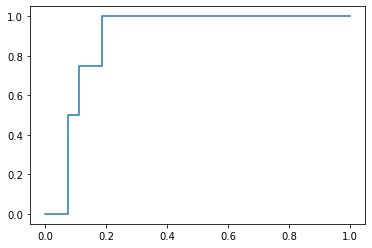

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

yTest = [0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
yPredicted = np.linspace(0.9, 0.1, num=len(yTest))
print(yPredicted)
print()

imbalanced_roc = roc_auc_score(yTest, yPredicted) # ~0.89
print(f"roc score: {imbalanced_roc}")
print()

fpr_imbalanced, tpr_imbalanced, threshold_imbalanced = sklearn.metrics.roc_curve(yTest, yPredicted, drop_intermediate=True)

print(f"fpr: \n{list(np.round(fpr_imbalanced,3))}")
print()
print(f"tpr: \n{list(np.round(tpr_imbalanced,3))}")
print()
print(f"thresholds: \n{list(np.round(threshold_imbalanced,3))}")
print()

plt.plot(fpr_imbalanced, tpr_imbalanced);

This diagram above says a thousand words. Because one perpetual question I had was how does class imbalance really plays a part in giving AUROC an overly optimistic picture. Note that the above I put `drop_intermediate=True`, which means we are only shown meaningful thresholds. In the thresholds above, we can see the fpr consistently is low, with low tpr at first. Then at the second last point, the fpr is 0.185 and tpr is 1, meaning we classified all positive points correctly. We see that this corresponding threshold is 0.687, and indeed, if we check the yTest and yPredicted, all the 1s have HIGHER probability than 0.687, which is the "trick here", thus once the threshold is set to > 0.687, all POSITIVE POINTS will be classified correctly, but this does not mean there is no FP, but now the FP is a lot at the expense, because we predict many as positive but it is actually negative, but fpr will be low, because fpr = fp/fp+tn, and even if fp is high, our tn is very big, pulling our denominator big, and as a result, making fpr seem deceptively low.

#### Cons: Uncalibrated

<div class="alert alert-block alert-danger">
<b>Uncalibrated:</b> 
A model with high AUROC does not necessarily imply a well calibrated model. By this I mean a model with all extreme predictions for of say, it predicts all positive ground truths to be 0.52 and all negative ground truths to be 0.51. This model has an AUC of 1, but the probabilities aren't helpful in the sense of identifying which purported positives are highest-risk. Because all of the positives are assigned the same posterior probability, they can't be differentiated. Note that models like logistic regression are naturally well calibrated, but models like neural networks output logits, and hence we have to apply `sigmoid` or `softmax` to make it probabilities. <p>

Below is the "phenomenon" that AUC of 1 but the models look bad. Notice that even though we have a perfect AUROC score of 1, the model is not at all confident with the predictions in the sense that we cannot pin point any two positive labels and say that one of them is of higher probability than the other. If you are not convinced, the below code illustrates the point and the plot shows you.
</div>

In [ ]:
y_true = [1, 0, 1, 0, 1, 0, 1, 0, 1, 1]

y_pred = [0.52, 0.51, 0.52, 0.51, 0.52, 0.51, 0.52, 0.51, 0.52, 0.52]

uncalibrated_roc = sklearn.metrics.roc_auc_score(y_true, y_pred)
print(f"roc score: {uncalibrated_roc}")

fpr_uncalibrated, tpr_uncalibrated, threshold_uncalibrated = sklearn.metrics.roc_curve(y_true, y_pred, drop_intermediate=True)

print(fpr_uncalibrated, tpr_uncalibrated, threshold_uncalibrated)

# Another example
# y_true = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
# y_pred = [0.99999, 0.98, 0.97, 0.96, 0.95, 0.94, 0.68139, 0.50961, 0.48880, 0.44951]
# full_score_example = sklearn.metrics.roc_auc_score(y_true, y_pred)  
# print(full_score_example) -> 1

roc score: 1.0
[0. 0. 1.] [0. 1. 1.] [1.52 0.52 0.51]


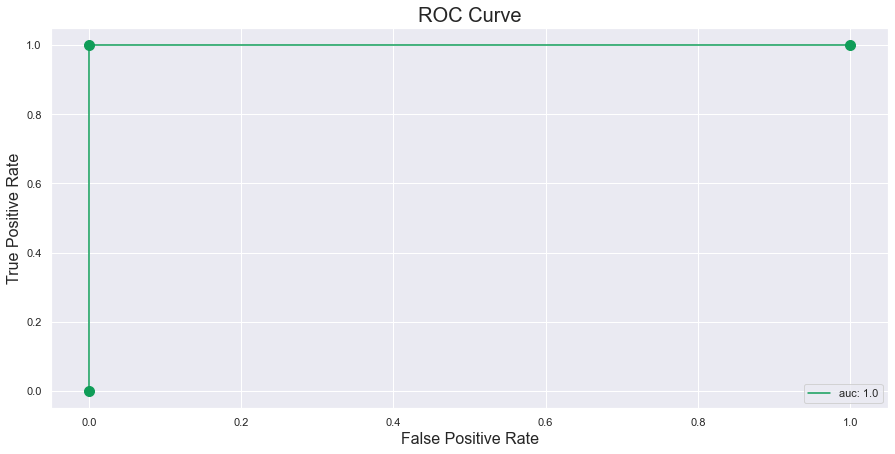

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(15, 7))

plt.scatter(fpr_uncalibrated, tpr_uncalibrated, color="#0F9D58", s=100)
plt.plot(fpr_uncalibrated, tpr_uncalibrated, color="#0F9D58", label = f"auc: {uncalibrated_roc}")
plt.title("ROC Curve", fontsize=20)
plt.legend(loc=4)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16);

### Implementation of ROC and AUC

This implementation follows closely to [Implementation of ROC - roc-curve-and-auc-from-scratch-in-numpy-visualized - TDS](https://towardsdatascience.com/roc-curve-and-auc-from-scratch-in-numpy-visualized-2612bb9459ab).

#### Step 1: Problem Setup

```python
y_true_binary = np.asarray([0, 0, 1, 1, 0, 0, 1, 1])
y_pred_binary = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
```

We have a binary classification problem with the targets and predictions shown above. We further note that the predictions are probabilities output from the **Sigmoid** layer in a logistic classifier.

In [ ]:
y_true_binary = np.asarray([0, 0, 1, 1, 0, 0, 1, 1])
y_pred_binary = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

#### Step 2: Define Threshold Range

For our classifier, our usual default threshold is as such:

```python
if y_pred_binary[i] > 0.5:
    assign y_pred_binary as positive class (+)
else:
    assign y_pred_binary as negative class (-)
```

Then it follows that different thresholds will result to different TPR and FPR. We can discretize our thresholds uniformly. Note that `scikit-learn` uses a different method to find the thresholds and are more optimized.

For starter, we will just set our threshold range from 0 to 1 with uniform interval of 0.1.

In [ ]:
threshold_range = np.arange(0, 11, 1) / 10
print(threshold_range)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


#### Step 3: Classify prediction according to threshold

The next step we need to do is to classify our `y_pred_binary` from probabilities into hard labels, a 0 or 1 label. We create a dictionary `y_pred_thresholded` which has the threshold as key, and the value is the corresponding hard labels.

```python
y_pred_thresholded = {
    0.0: [1, 1, 1, 1, 1, 1, 1, 1],
    0.1: [1, 1, 1, 1, 1, 1, 1, 1],
    0.2: [0, 1, 1, 1, 1, 1, 1, 1],
    0.3: [0, 0, 1, 1, 1, 1, 1, 1],
    0.4: [0, 0, 0, 1, 1, 1, 1, 1],
    0.5: [0, 0, 0, 0, 1, 1, 1, 1],
    0.6: [0, 0, 0, 0, 0, 1, 1, 1],
    0.7: [0, 0, 0, 0, 0, 0, 1, 1],
    0.8: [0, 0, 0, 0, 0, 0, 0, 1],
    0.9: [0, 0, 0, 0, 0, 0, 0, 0],
    1.0: [0, 0, 0, 0, 0, 0, 0, 0],
}
```

In [ ]:
y_pred_thresholded: Dict = {}

for threshold in threshold_range:
    
    if threshold not in y_pred_thresholded:
        y_pred_thresholded[threshold] = []

    for y_p in y_pred_binary:
        if y_p >= threshold:
            y_pred_thresholded[threshold].append(1)
        else:
            y_pred_thresholded[threshold].append(0)


#### Step 4: Calculate TPR and FPR 

Now we calculate the respective TPR and FPR for each thresholds's hard labels against the `y_true_binary`. We will make use of our `reighns_confusion_matrix` defined earlier to calculate.

```python
tpr_fpr = [
    [1.0, 1.0],
    [1.0, 1.0],
    [1.0, 0.75],
    [1.0, 0.5],
    [0.75, 0.5],
    [0.5, 0.5],
    [0.5, 0.25],
    [0.5, 0.0],
    [0.25, 0.0],
    [0.0, 0.0],
    [0.0, 0.0],
]
```

where the first element of the inner list is `tpr` and the second element is `fpr`.

In [ ]:
tpr_fpr: Dict = {"tpr": [], "fpr": []}

for y_pred in y_pred_thresholded.values():
    tp, fp, tn, fn = reighns_confusion_matrix(y_true_binary, y_pred)
    tpr = tp / (tp + fn)
    fpr = fp / (tn + fp)
    tpr_fpr["tpr"].append(tpr)
    tpr_fpr["fpr"].append(fpr)

print(tpr_fpr)

{'tpr': [1.0, 1.0, 1.0, 1.0, 0.75, 0.5, 0.5, 0.5, 0.25, 0.0, 0.0], 'fpr': [1.0, 1.0, 0.75, 0.5, 0.5, 0.5, 0.25, 0.0, 0.0, 0.0, 0.0]}


#### Step 5: Plot the points as ROC Curve

The main idea of ROC Curve is to plot various pairs of [TPR, FPR] at different threshold on the graph, as shown below. Note that we **reversed** our tpr and fpr to be in line with Scikit-Learn. It does not affect the end result.

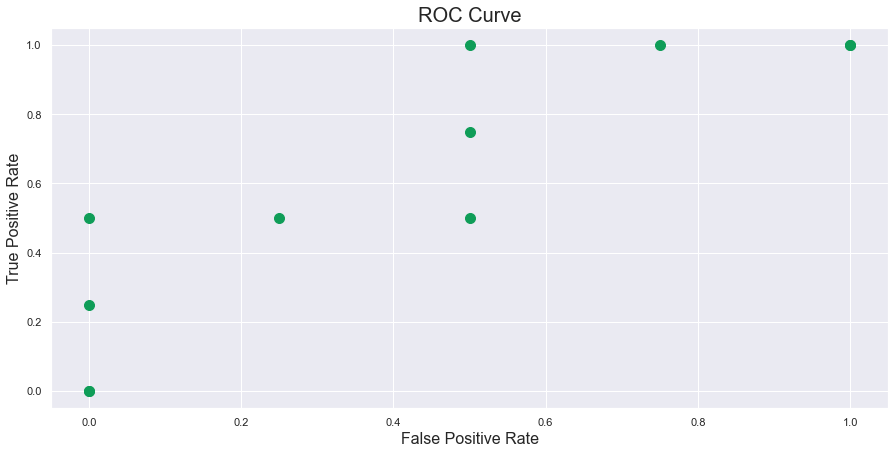

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(15, 7))

tpr_reighns = tpr_fpr["tpr"][::-1]
fpr_reighns = tpr_fpr["fpr"][::-1]

plt.scatter(fpr_reighns, tpr_reighns, color="#0F9D58", s=100)
plt.title("ROC Curve", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16);

Let us compare to the `scikit-learn's` version!

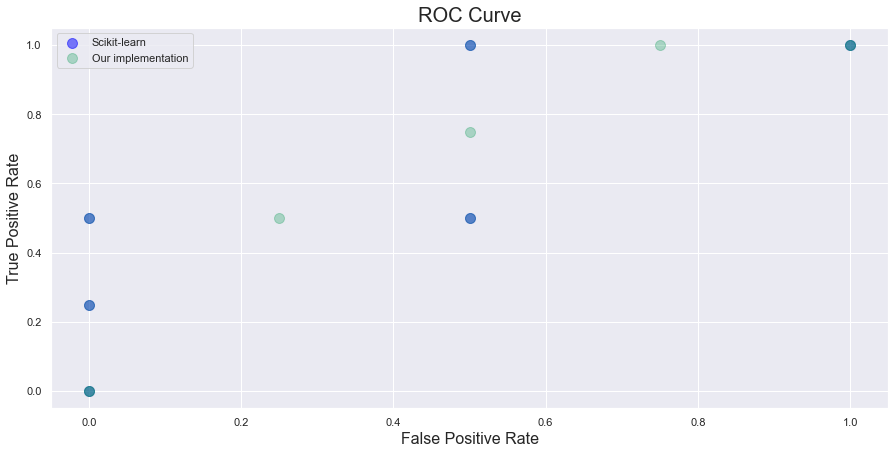

In [ ]:

from sklearn.metrics import roc_curve
fpr_sklearn, tpr_sklearn, thresholds_sklearn = roc_curve(y_true_binary, y_pred_binary)

plt.figure(figsize=(15, 7))
plt.scatter(fpr_sklearn, tpr_sklearn, s=100, alpha=0.5, color="blue", label="Scikit-learn")
plt.scatter(fpr_reighns, tpr_reighns, color="#0F9D58", s=100, alpha=0.3, label="Our implementation")
plt.title("ROC Curve", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.legend();

Notice that in Scikit-Learn's version, they have 3 less points that us, this is discussed in details in the reference links I appended below. But just know that the end result is the same when we go to AUC!

<div class="alert alert-block alert-danger">
<b>Starting and Ending Point:</b> 
Notice that the starting point and ending point of the ROC curve always start with (0, 0) and (1, 1). See the `y_pred_thresholded` we got earlier.
</div>

```python
y_true_binary = np.asarray([0, 0, 1, 1, 0, 0, 1, 1])

y_pred_thresholded = {
    0.0: [1, 1, 1, 1, 1, 1, 1, 1],
    0.1: [1, 1, 1, 1, 1, 1, 1, 1],
    0.2: [0, 1, 1, 1, 1, 1, 1, 1],
    0.3: [0, 0, 1, 1, 1, 1, 1, 1],
    0.4: [0, 0, 0, 1, 1, 1, 1, 1],
    0.5: [0, 0, 0, 0, 1, 1, 1, 1],
    0.6: [0, 0, 0, 0, 0, 1, 1, 1],
    0.7: [0, 0, 0, 0, 0, 0, 1, 1],
    0.8: [0, 0, 0, 0, 0, 0, 0, 1],
    0.9: [0, 0, 0, 0, 0, 0, 0, 0],
    1.0: [0, 0, 0, 0, 0, 0, 0, 0],
}
```

A bit of probing reveals that if you discretize your threshold from 0 to 1 inclusive, then it follows that at the threshold 1, everything is predicted as the negative class as shown, then by definition, TPR is 0 because the numerator of TPR is TP, and there is 0 TP because every single prediction made is of negative class, similarly, FPR is also 0 because the numerator of FPR is FP, and the model did not miss any negatives since it predicted every single one as negative.

---

The same logic can be applied to when the threshold is 0, we instead have FPR and TPR to be both 1.

#### Step 6: Area under ROC Curve

In the [Implementation of ROC - roc-curve-and-auc-from-scratch-in-numpy-visualized - TDS](https://towardsdatascience.com/roc-curve-and-auc-from-scratch-in-numpy-visualized-2612bb9459ab) visualization, we understand that we can approximate AUROC score by "integrating" over the rectangles. In a way, this is calculating areas of rectangles under the curve, as follows.

In [ ]:
rectangle_area = 0
for k in range(len(threshold_range)):
    rectangle_area += (fpr_reighns[k+1] - fpr_reighns[k]) * tpr_reighns[k]
    if k == (len(threshold_range) - 2): 
        break

In [ ]:
print(f"reighns roc_auc_score: {rectangle_area}")

from sklearn.metrics import roc_auc_score
roc_auc_sklearn = roc_auc_score(y_true_binary, y_pred_binary)
print(f"sklearn roc_auc_score: {roc_auc_sklearn}")

reighns roc_auc_score: 0.75
sklearn roc_auc_score: 0.75


In [ ]:
# alternatively, we can use np.trapz to calculate the area under the curve.
roc_area = np.trapz(y=tpr_reighns, x=fpr_reighns)
print(roc_area)

0.75


### Couple ROC with Brier Score

https://medium.com/@penggongting/understanding-roc-auc-pros-and-cons-why-is-bier-score-a-great-supplement-c7a0c976b679

### **Summary**

1. AUC is a threshold-free metrics capable of measuring the overall performance of binary classifier.
2. AUC should be used in binary classification. In multinomial classification, one-to-rest AUC would be an option using the average of each class.
3. AUC is a good metric when the rank of output probabilities is of interest.
4. Note that if you have 2 classes, then finding the AUROC of the positive class (class 1) is equivalent to 1 minus the AUROC of the negative class (class 0). This is not true when we deal with PR-curve.
5. **Although AUC is powerful, it is not a cure-all. AUC is not suitable for heavily imbalanced class distribution and when the goal is to have well-calibrated probabilities.**
6. Models with maximized AUC treat the weight between positive and negative class equally.
7. AUROC would be the metric to use if the goal of the model is to perform equally well on both classes. Image classification between cats & dogs is a good example because the performance on cats is equally important on dogs. 

    AUPRC would be the metric to use if the focus of the model is to identify correctly as many **positive** samples as possible. Take spam detectors for example, the goal is to find all the possible spams. Regular emails are not of interest at all — they overshadow the number of positives.

    There are no defined rules to select the suitable metrics. It really depends on the data and the application. It is important to think thoroughly about the purpose of the model before jumping into the modeling process.

    One thing to note here is that the PR AUC serves as an alternative metric. If the model doesn’t work after the metric is changed, there are still other remedies to deal with imbalanced data, such as downsampling/upsampling. We’ll cover it later in future posts.



### SKLEARN Definition of Binary Classification ROC-AUC


    sklearn.metrics.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)
    
    
**y_score: array-like of shape (n_samples,) or (n_samples, n_classes)**

Target scores. In the binary and multilabel cases, these can be either probability estimates or non-thresholded decision values (as returned by decision_function on some classifiers). In the multiclass case, these must be probability estimates which sum to 1. The binary case expects a shape (n_samples,), and the scores must be the scores of the class with the greater label. The multiclass and multilabel cases expect a shape (n_samples, n_classes). In the multiclass case, the order of the class scores must correspond to the order of labels, if provided, or else to the numerical or lexicographical order of the labels in y_true.

Understanding the binary case is important, it says that the binary case expects a list/array of shape `(n_samples,)`, a 1d-array, where the scores inside the 1d-array must be the scores of the **greater label**. In other words, if you have class 0 and 1, then the greater label is `np.argmax(0,1) = 1`. As a consequence, it is important that you should only pass the "positive class" which is the "greater label" here into the `y_score`. 

In multiclass, there are two cases, either you provide a `labels` argument in, say `labels = [0,2,1]` or `labels = [0,1,2]`, or if you do not provide, then the `y_score` will necessarily be in the order of the numerical/alphabetical order of the labels in `y_true`. In other words, if `y_true` has 3 unique labels: 0, 1 and 2; then the `y_score` will be a **2d-array** in the form of `y_score = [[0.2, 0.3, 0.5],[...],[...]]` where `y_score[0] = [0.2,0.3,0.5]` must correspond to class 1, 2 and 3 respectively, unless otherwise stated in `labels`.


### First Interpretation

Now ROC curve is a TPR vs FPR graph, and the AUC is the area under the curve literally. To find the ROC-AUC, we need to plot many different pairs of points on the graph, and compute the area under it.

As we can see from the above naive and simple example, there are a total of 6 pairs of points to plot. Those are from `fpr`, `tpr` respectively --> Allow me to further explain with this example where 1 is the positive class:

    y_true_1 = [0,0,1,1,0,0,1,1]
    y_preds_1 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

1. We need to initialize the thresholds with a large number usually - usually `roc_curve` is written so that ROC point corresponding to the highest threshold `(fpr[0], tpr[0])` is always `(0, 0)`. If this is not the case, a new threshold is created with an arbitrary value of `max(y_score)+1`. Therefore, in this case, we get 1.8 as the first threshold. This large number will ensure the `fpr, tpr` starts at (0,0).

2. Next, when the threshold is $T=0.8$, then one can see that `y_preds_1` has 1 predictions 1, so `y_preds_1=[0,0,0,0,0,0,0,1]` and hence we can calculate the FPR and TPR: FPR will be 0 because no negative samples 0 are misclassified as 1 in our prediction. TPR will be 0.25 because by definition TPR=TP/TP+FN = 1/1+3=0.25 by definition. Therefore `(fpr, tpr) = (0,0.25)`

3. $T=0.7 \rightarrow$ `y_preds_1 = [0,0,0,0,0,0,1,1]`, same logic, FPR will be 0 cause no negative samples 0 are classified as 1 by our classifier! But TPR will be 0.5 because TPR = TP/TP+FN = 2/2+2 = 0.5. Therefore `(fpr, tpr) = (0,0.5)`

4. We continue this way until we exhaust all thresholds given `[array([1.8, 0.8, 0.7, 0.5, 0.3, 0.1])]`. And we plot on the graph. 

5. How then, do we calculate the area under this curve? One can refer to the source code `auc` in `sklearn.metrics.auc` and see that they used **[Trapezoidal Rule](https://en.wikipedia.org/wiki/Trapezoidal_rule)** to solve it.

6. So one have a rough idea, how the `ROC-AUC` area is computed, and one has to bear in mind that the area is calculated over all thresholds (apparently not the case as `sklearn` discretized the thresholds to reduce computing time, so you will not see the full range of thresholds here). 




## **Precision-Recall Curve**

### Loss function and Decision Function

[Loss function and decision Function link](https://stats.stackexchange.com/questions/104988/what-is-the-difference-between-a-loss-function-and-decision-function)

A **decision function** is a function which takes a dataset as input and gives a decision as output. What the decision can be depends on the problem at hand. Examples include:

 - *Estimation problems:* the "decision" is the estimate.
 - *Hypothesis testing problems:* the decision is to reject or not reject the null hypothesis. Think of Linear Regression problems, they are mostly related to hypothesis testing.
 - *Classification problems:* the decision is to classify a new observation (or observations) into a category.
 - *Model selection problems:* the decision is to chose one of the candidate models.

Typically, there are an infinite number of decision functions available for a problem. If we for instance are interested in estimating the height of Swedish males based on ten observations $\mathbf{x}=(x_1,x_2,\ldots,x_{10})$, we can use any of the following decision functions $d(\mathbf{x})$:

 - The sample mean: $d(\mathbf{x})=\frac{1}{10}\sum_{i=1}^{10}x_i$.
 - The median of the sample: $d(\mathbf{x})=\mbox{median}(\mathbf{x})$
 - The geometric mean of the sample: $d(\mathbf{x})=\sqrt[10]{x_1\cdots x_{10}}$
 - The function that always returns 1: $d(\mathbf{x})=1$, regardless of the value of $\mathbf{x}$. Silly, yes, but it is nevertheless a valid decision function.

How then can we determine which of these decision functions to use? One way is to use a **loss function**, which describes the loss (or cost) associated with all possible decisions. Different decision functions will tend to lead to different types of mistakes. The loss function tells us which type of mistakes we should be more concerned about. The best decision function is the function that yields the lowest **expected loss**. What is meant by expected loss depends on the setting (in particular, whether we are talking about [frequentist][1] or [Bayesian][2] statistics).

**In summary:** 

 - Decision functions are used to make decisions based on data.
 - Loss functions are used to determine which decision function to use.


  [1]: http://en.wikipedia.org/wiki/Frequentist_inference
  [2]: http://en.wikipedia.org/wiki/Bayesian_statistics
  


### An extensive study on Precision-Recall Curve

Before I start, I will quote [Frank Harrell's first](https://www.fharrell.com/post/classification/) and [his second](http://www.fharrell.com/2017/03/damage-caused-by-classification.html) article. I will also use the links on stack exchange [here](https://stats.stackexchange.com/questions/312780/why-is-accuracy-not-the-best-measure-for-assessing-classification-models) and [here](https://stats.stackexchange.com/questions/368949/example-when-using-accuracy-as-an-outcome-measure-will-lead-to-a-wrong-conclusio) by [Stephan Kolassa](https://stats.stackexchange.com/users/1352/stephan-kolassa). They are really good and the entire intuition is from him, I will almost use his intuition verbatim and everything in this section will be credited to the links above; I just find it too difficult to phrase it in my own words because their answers are perfect.

Basically, let me put it up front now: ***Accuracy, Sensitivity and Specificity are one-sided or conditional versions of classification accuracy. As such they are also discontinuous improper accuracy scores, and optimizing them will result in the wrong model.***  



The `confusion matrix` and the `classification report` provide a very detailed analysis of a particular set of predictions. However, the predictions themselves already threw away a lot of information that is contained in the model - to explain this statement further: We consider the example of a logistic regression classifier, used to predict whether a patient has cancer (1, positive class) or not (0, negative class). We defined Y as our response variable, outputting only 1 or 0, while $X$ is the set of predictors.

In the case of our cancer classification model, (which we assume to be a logistic regression classifier), we remember that the positive class (class = 1) is the patient has cancer, and the negative class (class = 0) is the patient does not have cancer. And to delve a little deeper, our default classification threshold is:
    
$\begin{equation}
 Y=\begin{cases}
1, & \text{if $P(Y=1 ~|~X) \geq 0.5$}\\
0, & \text{if $P(Y=1~|~X) < 0.5$}\\
\end{cases} \end{equation}$

which means that whenever our logistic regression outputs a probability of the patient getting cancer is more than $0.5$, we classify the patient to be in the positive class (predict him/her to have cancer). When we use the `LogisticClassifier()` to fit and predict, we are actually predicting the probability $p(X)$, i.e.the probability of the patient having cancer given predictors X; Consequently, we need to further set a threshold, or to make a decision on whether to classify a patient as cancer or benign based on the probability we get from $$p(X) = \dfrac{e^{\beta_0}+\beta_1X_1+...+\beta_nX_n}{1+ e^{\beta_0}+\beta_1X_1+...+\beta_nX_n}$$

The threshold is defaulted to 0.5 in `predict_proba`. As we discussed earlier, most classifiers provide a `decision_function` or a `predict_proba` method to assess degrees of certainty about predictions. Making predictions can be seen as thresholding the output of `decision_function` or `predict_proba` at a certain fixed point; in binary classification we use 0 for the decision function and 0.5 for predict_proba as default.


<br>


To fully evaluate the effectiveness of a model, you must examine both precision and recall. Unfortunately, precision and recall are often in tension. That is, improving precision typically reduces recall and vice versa. Explore this notion by looking at the following figure, which shows 30 predictions made by an email classification model. Those to the right of the classification threshold are classified as "spam", while those to the left are classified as "not spam."

Always remember, do not ever just use a single metric like `recall, precision` to gauge your classifier. This is because your classifier (say `SVM()` may somehow trivially classify everything as the positive class,  and then you will get 100% recall).

### When to use Precision-Recall

[Precision-Recall curves should be used when there is a moderate to large class imbalance.](http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf). In particular, when the positive class

Precision and recall, however, don't consider true negatives and thus won't be affected by the relative imbalance (which is precisely why they're used for imbalanced datasets). 


[Kaggle Forum](https://www.kaggle.com/general/7517#41179)

As goes for any metric, your metric depends entirely on what I you mean to do with the data.

I think intuitively you can say that if your model needs to perform equally well on the positive class as the negative class (for example, for classifying images between cats and dogs, you would like the model to perform well on the cats as well as on the dogs. For this you would use the ROC AUC.

On the other hand, if you're not really interested in how the model performs on the negative class, but just want to make sure every positive prediction is correct (precision), and that you get as many of the positives predicted as positives as possible (recall), then you should choose PR AUC. For example, for detecting cancer, you don't care how many of the negative predictions are correct, you want to make sure all the positive predictions are correct, and that you don't miss any. (In fact, in this case missing a cancer would be worse then a false positive so you'd want to put more weight towards recall.)

True negatives need to be meaningful for ROC to be a good choice of measure. In his example, if we've got 1,000 pictures of cats and dogs and our model determines whether the picture is a cat (target = 0) or a dog (target = 1), we probably care just as much about getting the cats right as the dogs, and so ROC is a good choice of metric.

If instead, we've got a collection of 1,000,000 pictures and we build a model to try to identify the 1,000 dog pictures mixed in it, correctly identifying "not-dog" pictures is not quite as useful. Instead, it makes more sense to measure how often a picture is a dog when our model says it's a dog (i.e., precision) and how many of the dogs in the picture set we found (i.e., recall).




<div class="alert alert-block alert-info">
<b>Perspective:</b> In the cancer example above, your AUROC score might be very bad, simply because your False Positives might be high, as a result of minimizing False Negatives, but your AUPRC might be good, because you are maximizing precision!
</div>

### When NOT to use Precision-Recall

<div class="alert alert-block alert-danger">
<b>Majority Negative:</b> 
Notice that PR curve does not have TN in their equations, and this implies that PR curves are useful when there are minority positive samples and majority negative samples. But if it is the other way round, with minority negative samples, then PR curve will not tell you useful things.
</div>

### Implementation of PR-Curve

## The Debate: AUROC vs AUPRC

I just finished reading this discussion. They argue that PR AUC is better than ROC AUC on imbalanced dataset.

For example, we have 10 samples in test dataset. 9 samples are positive and 1 is negative. We have a terrible model which predicts everything positive. Thus, we will have a metric that TP = 9, FP = 1, TN = 0, FN = 0.

Then, Precision = 0.9, Recall = 1.0. The precision and recall are both very high, but we have a poor classifier.

On the other hand, TPR = TP/(TP+FN) = 1.0, FPR = FP/(FP+TN) = 1.0. Because the FPR is very high, we can identify that this is not a good classifier.

Clearly, ROC is better than PR on imbalanced datasets. Can somebody explain why PR is better?

---

Usually when I do imbalanced models, even balanced models, I look at PR for ALL my classes.

In your example, yes, your positive class has P = 0.9 and R = 1.0. But what you should look at are ALL your classes. So for your negative class, your P = 0 and your R = 0. And you usually don't just look at PR scores individually. You want to look at F1-score (F1 macro or F1 micro, depending on your problem) that is a harmonic average of your PR scores for both class 1 and class 0. Your class 1 PR score is super good, but combine that with your class 0 PR score, your F1-score will be TERRIBLE, which is the correct conclusion for your scenario.

TL,DR: Look at PR scores for ALL your classes, and combine them with a metric like F1-score to have a realistic conclusion about your model performance. The F1-score for your scenario will be TERRIBLE, which is the correct conclusion for your scenario.

# **Metrics for Multi-Class-Label Classification**

Most Metrics discussed in Binary Classification can be extended to Multi-Class Classification.

## Multi-Class ROC

### Intuition

ROC is originally used for Binary Classification only, a natural extension to Multi-Class model is the 
In multi-class model, we can plot N number of AUC ROC Curves for N number classes using One vs ALL methodology. So for Example, If you have three classes named X, Y and Z, you will have one ROC for X classified against Y and Z, another ROC for Y classified against X and Z, and a third one of Z classified against Y and X.


Firstly, you need to make use of the below code in [source](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/metrics/_ranking.py#L690) where we are using the concept of One-Vs-All (ovr) and first thing first, for all `y_true` labels, we need to `label_binarize` them. As we can see, we must pass in the `y_true` and `classes` in which if our classes are `[0,1,2,3,4,5]` then we need to specify in the `labels` argument of `roc_auc_curve`. If we do not specify, the `_encode` will help us as well, so it is up to one's preference if your labels order matter.

```python
else:
    # ovr is same as multi-label
    y_true_multilabel = label_binarize(y_true, classes=classes)
    return _average_binary_score(_binary_roc_auc_score, y_true_multilabel,
                                 y_score, average,
                                 sample_weight=sample_weight)
```

### Implementation of OVR Multi-Class ROC

#### Step 1: Problem Setup

- Multi-Class: 3 classes of 0, 1 and 2. 
- Number of samples: 4 
- Predictions: output using Softmax

In [ ]:
import scipy
y_true_multiclass = np.asarray([0, 1, 2, 1])

y_logit_multiclass = np.asarray(
    [
        [0.0802, 0.0347, 0.05],
        [0.2640, -0.0701, 0.03],
        [-0.0087, 0.0502, 0.0039],
        [0.0496, 0.0059, 0.0123],
    ]
)

y_pred_multiclass = scipy.special.softmax(y_logit_multiclass, axis=1)

y_pred_multiclass = np.asarray(
    [
        [0.34, 0.33, 0.33],
        [0.4, 0.29, 0.32], 
        [0.33, 0.35, 0.33], 
        [0.34, 0.33, 0.33]]
)


#### Step 2: Binarize 

We need to binarize the `y_true_multiclass`.

```python
array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]])
```

where we need to interpret as follows:

| Class 1 | Class 2 | Class 3 |
| --      | --      | --      |
| 1       | 0       | 0       |
| 0       | 1       | 0       |
| 0       | 0       | 1       |
| 0       | 1       | 0       |

where [1,0,0,0] (first column) represents the case where class 1 is the **positive class** and class 2 and 3 are considered the negative class (both are class 0). 

| Class 1 Preds | Class 2 Preds| Class 3 Preds |
| --      | --      | --      |
| 0.34       | 0.33       | 0.33       |
| 0.4       | 0.29       | 0.32       |
| 0.33       | 0.35       | 0.33       |
| 0.34       | 0.33       | 0.33       |

where [0.34, 0.4, 0.33, 0.34] (first column) represents the probability of class 1 being the positive class. And to avoid confusion, the second column [0.33, 0.29, 0.35, 0.33] represents the probability of class 2 being the positive class (class 1).

---

Note that I labelled the above as class 1, 2 and 3 but in our code it is class 0, 1 and 2. This does not affect the ultimate score but just note in case of confusion.

In [ ]:
y_binarize=sklearn.preprocessing.label_binarize(y_true_multiclass, classes=[0,1,2])
print(y_binarize)

[[1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]]


#### Step 3: ROC score for each class

At this step, we calculate the ROC score for each class. We have have 3 different scores, one for each class. That is to say, the first score is class 0 vs the rest, where we treated class 0 as the positive class.

In [ ]:
num_classes = 3
fpr_dict = dict()
tpr_dict = dict()
threshold_dict = dict()
roc_auc_dict = dict()

for label_num in range(num_classes):
    y_true_for_curr_class = y_binarize[:, label_num]
    y_pred_for_curr_class = y_pred_multiclass[:, label_num]
    
    # calculate fpr,tpr and thresholds across various decision thresholds; pos_label = 1 because one hot encode guarantees it
    
    fpr_dict[label_num], tpr_dict[label_num], threshold_dict[label_num] = sklearn.metrics.roc_curve(
        y_true=y_true_for_curr_class, y_score=y_pred_for_curr_class, pos_label=1
    )
    roc_auc_dict[label_num] = sklearn.metrics.auc(fpr_dict[label_num], tpr_dict[label_num])
    
    print(f"ROC score for class {label_num} is {roc_auc_dict[label_num]}. \nNote we are considering class {label_num} as the positive class and treating other classes as negative class.\n")

print(fpr_dict)
print(tpr_dict)
print(threshold_dict)

ROC score for class 0 is 0.5. 
Note we are considering class 0 as the positive class and treating other classes as negative class.

ROC score for class 1 is 0.125. 
Note we are considering class 1 as the positive class and treating other classes as negative class.

ROC score for class 2 is 0.6666666666666667. 
Note we are considering class 2 as the positive class and treating other classes as negative class.

{0: array([0.        , 0.33333333, 0.66666667, 1.        ]), 1: array([0. , 0.5, 1. , 1. ]), 2: array([0.        , 0.66666667, 1.        ])}
{0: array([0., 0., 1., 1.]), 1: array([0. , 0. , 0.5, 1. ]), 2: array([0., 1., 1.])}
{0: array([1.4 , 0.4 , 0.34, 0.33]), 1: array([1.35, 0.35, 0.33, 0.29]), 2: array([1.33, 0.33, 0.32])}


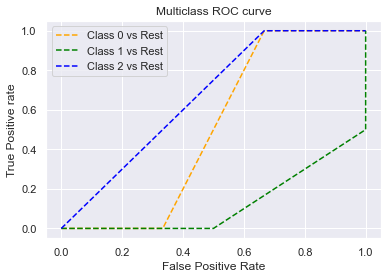

In [ ]:
# plotting    
plt.plot(fpr_dict[0], tpr_dict[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr_dict[1], tpr_dict[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr_dict[2], tpr_dict[2], linestyle='--',color='blue', label='Class 2 vs Rest')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

#### Step 4: One Vs Rest

We will do a arithmetic mean over the scores we get. This concludes the OvR algorithm.

In [ ]:
macro_average_roc_score = np.mean(list(roc_auc_dict.values()))
print(macro_average_roc_score)

0.4305555555555556


#### Step 5: Modularize

In [ ]:
# This code belows also WORKS for Binary class if you are using Softmax Predictions!
# replicating from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings
def multiclass_roc(y_true, y_logit, config):
    label_dict = dict()
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    roc_scores = []
    for label_num in range(len(config.class_list)):

        # get y_true_multilabel binarized version for each loop (end of each epoch)
        y_true_multiclass_array = sklearn.preprocessing.label_binarize(
            y_true, classes=config.class_list
        )

        y_true_for_curr_class = y_true_multiclass_array[:, label_num]
        y_pred_for_curr_class = y_logit[:, label_num]
        # calculate fpr,tpr and thresholds across various decision thresholds
        # pos_label = 1 because one hot encode guarantees it
        fpr[label_num], tpr[label_num], _ = sklearn.metrics.roc_curve(
            y_true=y_true_for_curr_class, y_score=y_pred_for_curr_class, pos_label=1
        )
        roc_auc[label_num] = sklearn.metrics.auc(fpr[label_num], tpr[label_num])
        roc_scores.append(roc_auc[label_num])
        # if binary class, the one hot encode will (n_samples,1) and therefore will only need to slice [:,0] ONLY.
        # that is why usually for binary class, we do not need to use this piece of code, just for testing purposes.
        # However, it will now treat our 0 (negative class) as positive, hence returning the roc for 0, in which case
        # to get both 0 and 1, you just need to use 1-roc(0)value
        if config.num_classes == 2:
            roc_auc[config.class_list[1]] = 1 - roc_auc[label_num]
            break
    avg_roc_score = np.mean(roc_scores)
    return roc_auc, avg_roc_score

## Multi-Label ROC

Incidentally, the way we compute OVR Multi-Class ROC can be used in Multi-Label ROC as well.

# Quadratic Weighted Kappa

The below explanation will correspond to my [notebook during the PANDAS competition](https://www.kaggle.com/reighns/understanding-the-quadratic-weighted-kappa/).

 ## Table of Contents
1. [Intuition of QWK](#intuition)
2. [Step 1: Create the NxN histogram matrix O](#confusion) <br>
3. [Step 2: Create the Weighted Matrix w](#weighted)<br>
4. [Step 3: Create the Expected Matrix](#expected) <br>
5. [Step 4: Final Step: Weighted Kappa formula and Its python codes](#qwk) 

    

## **Intuition of QWK** <a id="intuition"></a> <a id="intuition"></a>

TLDR: one can skip to the last section on the python code implementation of QWK and also take reference to [CPMP's Fast QWK Computation](https://www.kaggle.com/c/prostate-cancer-grade-assessment/discussion/145105) as well.

Kappa or Cohen’s Kappa is like classification accuracy, except that it is normalized at the baseline of random chance on your dataset: It basically tells you how much better your classifier is performing over the performance of a classifier that simply guesses at random according to the frequency of each class.

First off, we define the formula exactly as mentioned. Quoting from the evaluation page: **Submissions are scored based on the quadratic weighted kappa, which measures the agreement between two outcomes. This metric typically varies from 0 (random agreement) to 1 (complete agreement). In the event that there is less agreement than expected by chance, the metric may go below 0.** 

**The quadratic weighted kappa is calculated as follows. First, an N x N histogram matrix O is constructed, such that $O_{i,j}$ corresponds to the number of `isup_grade`'s i (actual) that received a predicted value j. An N-by-N matrix of weights, w, is calculated based on the difference between actual and predicted values:**

$$w_{i,j} = \dfrac{(i-j)^2}{(N-1)^2}$$

<br>

**An N-by-N histogram matrix of expected outcomes, E, is calculated assuming that there is** ***no correlation*** **between values.This is calculated as the outer product between the actual histogram vector of outcomes and the predicted histogram vector, normalized such that E and O have the same sum. **

<br>

Finally, from these three matrices, the quadratic weighted kappa is calculated as:


$$\kappa = 1 - \dfrac{\sum_{i,j}\text{w}_{i,j}O_{i,j}}{\sum_{i,j}\text{w}_{i,j}E_{i,j}}$$

where $w$ is the weighted matrix, $O$ is the histogram matrix and $E$ being the expected matrix.

## **Step 1: Create the NxN histogram matrix O** <a id="confusion"></a>

***Warning: This is a counter example to the wrong usage of Quadratic Weighted Kappa. We shall see why soon.***

***Warning: This is a counter example to the wrong usage of Quadratic Weighted Kappa. We shall see why soon.***

***Warning: This is a counter example to the wrong usage of Quadratic Weighted Kappa. We shall see why soon.***

<br>

***Reminder: Although it is a counter example, it still illustrates what a NxN histogram matrix is! We will now call our histogram matrix C instead because in actual fact, the histogram matrix is merely a multi class confusion matrix between actual and predicted values***

We use a naive example where there are 5 classes (note our competition is_up grade has 6 classes; but this is just an example. Our `y_true` is the ground truth labels and correspondingly, our `y_pred` is the predicted values.

In [ ]:
y_true = pd.Series(['cat',  'cat', 'dog', 'cat',   'cat',  'cat', 'pig',  'pig', 'hen', 'pig'], name = 'Actual')
y_pred   = pd.Series(['bird', 'hen', 'pig','bird',  'bird', 'bird', 'pig', 'pig', 'hen', 'pig'], name = 'Predicted')

print("Ground truth:\n{}".format(y_true))
print("-"*40)
print("Predicted Values:\n{}".format(y_pred))

Ground truth:
0    cat
1    cat
2    dog
3    cat
4    cat
5    cat
6    pig
7    pig
8    hen
9    pig
Name: Actual, dtype: object
----------------------------------------
Predicted Values:
0    bird
1     hen
2     pig
3    bird
4    bird
5    bird
6     pig
7     pig
8     hen
9     pig
Name: Predicted, dtype: object


First, an N x N confusion matrix **C** is constructed, such that $\text{C}_{i,j}$ is the entry that corresponds to the **number of animal i (actual) that received a predicted value j**. 

<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


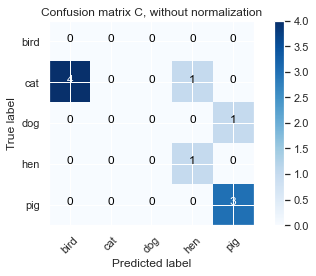

In [ ]:
classes= ['bird','cat','dog','hen', 'pig']

# thank you https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cnf_matrix = confusion_matrix(y_true, y_pred,labels=['bird','cat','dog','hen', 'pig'],)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['bird','cat','dog','hen', 'pig'],
                      title='Confusion matrix C, without normalization')

### Example using our competition's dataset

The above matrix is a **multi class confusion matrix**. As an example, for the 2nd row, we predicted 4 cats to be birds, and 1 cat to be predicted as hen. More compactly, it can be represented as the matrix $C_{2,1}$ = 4.

We can easily reconcile our example above to relate back to our competition: **After the biopsy is assigned a Gleason score, it is converted into an ISUP grade on a 1-5 scale**. For now, I will include the label **0** because it is the background/non-tissue. 

What I do next is to take the ground truth and call it `y_true` which is a series. I then generate a dummy `y_pred` by using `np.random.choice` and randomly generate numbers from 0 to 5.

In [ ]:
train = pd.read_csv("../data/datasets/prostate-cancer-grade-assessment-train.csv")
y_true = train.isup_grade
y_true

y_pred = np.random.choice(6, 10616, replace=True)
y_pred = pd.Series(y_pred)
y_pred

0        0
1        0
2        4
3        4
4        0
        ..
10611    0
10612    5
10613    0
10614    2
10615    4
Name: isup_grade, Length: 10616, dtype: int64

0        2
1        2
2        4
3        1
4        5
        ..
10611    2
10612    2
10613    1
10614    5
10615    1
Length: 10616, dtype: int32

The following confusion matrix, is what we mean by the "N by N" (6 by 6) **histogram matrix**. 

Confusion matrix, without normalization


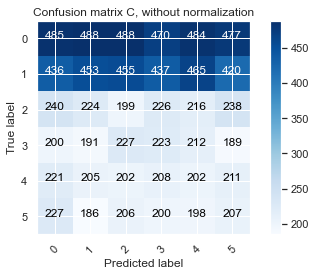

In [ ]:
cm = confusion_matrix(y_true, y_pred,labels=[0,1,2,3,4,5],)
plot_confusion_matrix(cm, classes=[0,1,2,3,4,5],
                      title='Confusion matrix C, without normalization')

***So far we have settled the first portion, construction the histogram matrix.***

## **Step 2: Create the Weighted Matrix w** <a id ="weighted"></a>

An N-by-N matrix of weights, w, is calculated based on the difference between actual and predicted rating scores. The formula is as follows:  $$w_{i,j} = \dfrac{(i-j)^2}{(N-1)^2}$$


Under Step-2, each element is weighted. Predictions that are further away from actuals are marked harshly than predictions that are closer to actuals. However, I suddenly realized that these animals above have no obvious hierarchy in them. Therefore, it is not correct to say that predicting a cat as a bird is any better/worse off than predicting a cat as hen.

**Consequently, this is a realization. Because now I start to understand why certain competitions use metrics like quadratic weighted kappa!** Consider the same example as animals just now, but instead of animals, we change to **isup_grade**). So there is an inherent order within the **isup_grade** 0 - 5 such that 0 and 1 is closer than 0 and 2, 1 and 2 is closer to 1 and 3 etc. $$0 > 1 > 2 > 3 > 4 > 5$$

<br>

For example, let's use a simplified example:

    y_true = [2,2,2,1,2,3,4,5,0,1]
    y_pred = [1,2,4,1,2,3,4,5,0,1]
    
As a result, our purpose of the weighted matrix is to allocate a higher penalty score if our prediction is further away from the actual value. That is, if our **isup_grade** is 2 but we predicted it as 1 (see the example), then based on our formula above, we have i = 2 and j = 1 (entry $C_{2,1}$), the penalty is $$\dfrac{(2-1)^2}{(5-1)^2}  = 0.0625$$ but if our **isup_grade** is 2 and we predicted it as 4 (see the example), then the penalty involved is higher $$\dfrac{(2-4)^2}{(5-1)^2} = 0.25$$

Indeed, the weight matrix helped us assign a heavier penalty to predicting 2 as 4 than 2 as 1.

***Lastly, we also observe that the formula will give us 0 for the diagonals of the weighted matrix. This means penalty is 0 whenever we correctly predict something.***

To calculate weighted matrix in python code, here is the code with reference to [Aman Arora](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps).

In [ ]:
# We construct the weighted matrix starting from a zero matrix, it is like constructing a 
# list, we usually start from an empty list and add things inside using loops.

def weighted_matrix(N):
    weighted = np.zeros((N,N)) 
    for i in range(len(weighted)):
        for j in range(len(weighted)):
            weighted[i][j] = float(((i-j)**2)/(N-1)**2) 
    return weighted
        
print(weighted_matrix(5))

[[0.   0.06 0.25 0.56 1.  ]
 [0.06 0.   0.06 0.25 0.56]
 [0.25 0.06 0.   0.06 0.25]
 [0.56 0.25 0.06 0.   0.06]
 [1.   0.56 0.25 0.06 0.  ]]


***Remember, the further away from the diagonal you get, the worse off is your prediction and it will be penalized harder by a bigger weight.***  As you can easily infer from the weighted matrix above, we use the first row as an example in case one did not understand. Basically, the weighted matrix's first row's first element is 0, because it means we predicted correctly and no penalty is meted out; but as we move further to the left, you can see that the punishment gets harsher and harsher: $$0 < 0.06 < 0.25 < 0.56 < 1$$

## **Step 3: Create the Expected Matrix** <a id ="expected"></a>

In [ ]:
## dummy example 
actual = pd.Series([2,2,2,3,4,5,5,5,5,5]) 
pred   = pd.Series([2,2,2,3,2,1,1,1,1,3]) 
C = confusion_matrix(actual, pred)

N=5
act_hist=np.zeros([N])
for item in actual: 
    act_hist[item - 1]+=1
    
pred_hist=np.zeros([N])
for item in pred: 
    pred_hist[item - 1]+=1
    

print(f'Actuals value counts:{act_hist}, \nPrediction value counts:{pred_hist}')

Actuals value counts:[0. 3. 1. 1. 5.], 
Prediction value counts:[4. 4. 2. 0. 0.]


This part is the most difficult to understand, especially for someone who has little statistic backgrounds (mind you when I was majoring in applied math back then, I only took **one** statistic module in my whole tenure.) Googling the idea of expected matrix is not apparently clear to me, but luckily someone pointed to me to read expected frequency of Chi-Square test and then and, there I start to slowly understand.

For the purpose of better understanding, we call our actual values to be rater A and our prediction model to be rater B. We want to quantify the agreement between rater A and rater B. Here are some terminologies to get hold of first.

- There are a total number of $k = 5$ classes in this example;
- There are a total number of $n = 10$ observations in this example;
- Define Y to be the random variable that rater A has chosen (aka our actual classes 1,2,3,4,5);
- and $\widehat{Y}$ be the random variable that rater $B$ has chosen (aka our predicted classes 1,2,3,4,5 by rater B)
- $r_i$ be the i-th entry of the column vector for actual value counts shown above, $c_i$ be the i-th entry of the column vector for prediction value counts shown above.
<br>

Then the probability of rater A choosing class 2 and rater B choosing class 2 for example, is given by $$P(Y = 2 \text{ and } \widehat{Y} = 2)  = P(Y = 2) \cdot P(\widehat{Y} = 2) = 30\% \times 40\%  = 12\%$$

This is under the assumption that both raters are **independent of each other**. Note that $P(Y = 2) = 30\%$ because as we see from the actual value counts of rater $A$, there are a total of 3 class 2's and therefore the probability of Y being 2 is just the proportion. Similarly, we calculate $\widehat{Y}$ the same way.

In general, the formula of rater A choosing class i and rater B choosing (predicting) class j is given as follows: $$P(Y = i \text{ and }  \widehat{Y} = j) =  P(Y = i) \times P (\widehat{Y} = j)$$

<br>


Now the real question comes: On average, if you have $n$ number of points to predict, how many times (what is the frequency) would you **expect** to see rater A choose class i and rater B choose class j.

To reiterate, recall that the probability of the actual class being 1 **and (super important word here, it means a joint distribution)** and the predicted class to be 1 as well is $P(Y = 1 \text{ and }  \widehat{Y} = 1)$, similarly, the probability of the actual class being 1 and the predicted class to be 2 is $P(Y = 1 \text{ and }  \widehat{Y} = 2)$. Generalizing, the probability of the actual class being $i$ and the predicted class being $j$ is the joint probability $$P(Y = i \text{ and }  \widehat{Y} = j)$$

So the intuition lies here: based on the joint probability above, what is the expected number of times (frequency) that $Y = i$ and $\widehat{Y} = j$ happened (this means Y is i but rater B predict $\widehat{Y}$ as j) out of 10 times? Easy, just use $n \times P(Y = i \text{ and }  \widehat{Y} = j)$. So for rater B, our prediction model, **by just using theoretical probability**, should have $n \times P(Y = i \text{ and }  \widehat{Y} = j)$ for each $i,j$. But in reality, this may not be the case. Reconcile this idea with the classic coin toss example:

- **Example on coin toss:** Expected frequency is defined as the number of times that we predict an event will occur based on a calculation using theoretical probabilities. You know how a coin has two sides, heads or tails? That means that the probability of the coin landing on any one side is 50% (or 1/2, because it can land on one side out of two possible sides). If you flip a coin 1,000 times, how many times would you expect to get heads? About half the time, or 500 out of the 1,000 flips. To calculate the expected frequency, all we need to do is multiply the total number of tosses (1,000) by the probability of getting a heads (1/2), and we get 1,000 * 1/2 = 500 heads. if event A has prob of p happening, and sample size of n, then the average or expected number of times that A happens is $np$. The expected frequency of heads is 500 out of 1,000 total tosses. The expected frequency is based on our knowledge of probability - we haven't actually done any coin tossing. However, if we had enough time on our hands, we could actually flip a coin 1,000 times to experimentally test our prediction. If we did this, we would be calculating the experimental frequency. The experimental frequency is defined as the number of times that we observe an event to occur when we actually perform an experiment, test, or trial in real life. If you flipped a coin 1,000 times and it landed on heads 479 times, then the experimental frequency of heads is 479.

    But wait - didn't we predict the coin would land on heads 500 times? Why did it actually land on heads only 479 times? Well, the expected frequency was just that - what we expected to happen, based on our knowledge of probability. There are no guarantees when it comes to probability, what we expect to happen might differ from what actually happens. 

<br>

Since we know $$E_{2,2} = 10 \times P(Y = 2 \text{ and } \widehat{Y} = 2)  = 10 \times P(Y = 2) \cdot P(\widehat{Y} = 2) = 10 \times 30\% \times 40\%  = 1.2$$

This $E_{2,2}$ means that we only expect the rater A to choose 2 and rater B to choose 2 at the same time only 1.2 times out of 10 times. In other words, our predicted model classify 2 as 2 1.2 times. However, from our observations in our matrix C (confusion/histogram matrix), rater A choosing 2 and rater B choosing 2 have a frequency of 3! In other words, our predicted model classified 2 as 2 three times! So we kinda exceeded expectation for this particular configuration.

$$C = \begin{bmatrix}
0 & 0 & 0 & 0 & 0\\
0 & 3 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0\\
0 & 1 & 0 & 0 & 0\\
4 & 0 & 1 & 0 & 0\\
\end{bmatrix}$$

Let me give you one more example, $$E_{5,2} = 10 \times P(Y = 5 \text{ and } \widehat{Y} = 2) = 10 \times P(Y = 5) \cdot P(\widehat{Y} = 2) = 10 \times 50\% \times 40\%  = 2$$

This means that we only expect the rater A to choose 5 and rater B to choose 2 at the same time only 2 times out of 10 times! But in reality, our observations say that our rater B classified 5 as 2 zero times! 


We calculate $E_{i,j}$ given by the formula: $$E_{i,j} = n \times P(Y = i \text{ and }  \widehat{Y} = j) = n \times P(Y = i) \times P (\widehat{Y} = j) = n \times \dfrac{r_i}{n} \times \dfrac{c_j}{n}$$

$$E = \begin{bmatrix}
0 & 0 & 0 & 0 & 0\\
1.2 & 1.2 & 0.6 & 0 & 0 \\
0.4 & 0.4 & 0.2 & 0 & 0\\
0.4 & 0.4 & 0.2 & 0 & 0\\
2 & 2 & 1 & 0 & 0\\
\end{bmatrix}$$

Note $r_i \times c_j$ is the $(i,j)$ entry of the outer product between the actual histogram vector of outcomes (actual value counts) and the predicted histogram vector (prediction value counts).

What does the random chance mean here? Simple, it just means that the probability for rater A (actual) to be class i AND for rater B (predicted) to be class j is $p\%$ (say 10%). Therefore, if we have made 100 predictions, random chance aka the theoratical probability tells us you should only have $100 \times 10\% = 10$ predictions to be of this configuration (rater A class i AND rater B class j).

#### Writing out the expected matrix in python

So to get the expected matrix, E, is calculated assuming that there is no correlation between values.  This is calculated as the outer product between the actual histogram vector of outcomes and the predicted histogram vector, normalized such that E and C have the same sum. Note carefully below that we do not need to normalize both, we just need to normalize E to the same sum as C.

In [ ]:
E = np.outer(act_hist, pred_hist)/10


E
C

array([[0. , 0. , 0. , 0. , 0. ],
       [1.2, 1.2, 0.6, 0. , 0. ],
       [0.4, 0.4, 0.2, 0. , 0. ],
       [0.4, 0.4, 0.2, 0. , 0. ],
       [2. , 2. , 1. , 0. , 0. ]])

array([[0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [4, 0, 1, 0, 0]], dtype=int64)

## **Step 4: Final Step: Weighted Kappa formula and Its python codes** <a id="qwk"></a>
 
From these three matrices: E, C and weighted, the quadratic weighted kappa is calculated as: 

$$\kappa = 1 - \dfrac{\sum_{i,j}\text{weighted}_{i,j}C_{i,j}}{\sum_{i,j}\text{weighted}_{i,j}E_{i,j}}$$

Note that a higher value generally means your prediction model is way better than a random model, but there is no consensus on which value is really good or bad.

$$\text{Weighted} = \begin{bmatrix}
0 & 0.0625 & 0.25 & 0.5625 & 1\\
0.0625 & 0 & 0.0625 & 0.25 & 0.5625 \\
0.25 & 0.0625 & 0 & 0.0625 & 0.25\\
0.5625 & 0.25 & 0.0625 & 0 & 0.0625\\
1 & 0.5625 & 0.25 & 0.0625 & 0\\
\end{bmatrix}$$

The notation $\sum_{i,j}\text{W}_{i,j}C_{i,j}$ is just $$\sum_{i=1}^{k}\sum_{j=1}^{k} W_{i,j} C_{i,j} = (W_{1,1}C_{1,1} + W_{1,2}C_{1,2} + ...+ W_{1,k}C_{1,k}) + (W_{2,1}C_{2,1}+...+W_{2,k}C_{2,k}) +...+(W_{k,1}C_{k,1}+...+W_{k,k}C_{k,k})$$

To put our understanding into perspective, consider just one entry $W_{5,1}C_{5,1} = 1 \times 4 = 4$. This roughly means that our predicted model classified class 5 as class 1 FOUR times (re: $C_{5,1} = 4$), and since class 5 is so far away from class 1, we need to **punish** this wrong prediction more than the others. And we did see that the corresponding weight $W_{5,1} = 1$ is the highest weight.

Consequently, the numerator being $\sum_{i,j}\text{W}_{i,j}C_{i,j}$ calculates the total "penalty cost" for the rater A (our predicted model), and similarly, $\sum_{i,j}\text{W}_{i,j}E_{i,j}$ calculates the total "penalty cost" for the rater B (our "expected" model). Therefore, you can think both values (num and den) as a cost function, and the lesser the better. And kappa formula tells us, if our $\sum_{i,j}\text{W}_{i,j}C_{i,j}$ is significantly smaller than $\sum_{i,j}\text{W}_{i,j}E_{i,j}$, this will yield a very small value of $$\dfrac{\sum_{i,j}\text{weighted}_{i,j}C_{i,j}}{\sum_{i,j}\text{weighted}_{i,j}E_{i,j}}$$ which will yield a very high kappa value - signifying a better model.

In [ ]:
# Method 1
# apply the weights to the confusion matrix
weighted = weighted_matrix(5)
num = np.sum(np.multiply(weighted, C))
# apply the weights to the histograms
den = np.sum(np.multiply(weighted, E))

kappa = 1-np.divide(num,den)
kappa

-0.13924050632911378

In [ ]:
# Method 2

num=0
den=0
for i in range(len(weighted)):
    for j in range(len(weighted)):
        num+=weighted[i][j]*C[i][j]
        den+=weighted[i][j]*E[i][j]

weighted_kappa = (1 - (num/den)); weighted_kappa

-0.13924050632911378

In [ ]:
# Method 3: Just use sk learn library

cohen_kappa_score(actual, pred, labels=None, weights= 'quadratic', sample_weight=None)

-0.13924050632911378

Just a side note that one can also use SK learn's cohen_kappa_score function calculate the quadratic weighted kappa in this competition, with weights set to quadratic. Also please do refer to [CPMP's discussion topic for fast QWK computation](https://www.kaggle.com/c/prostate-cancer-grade-assessment/discussion/145105)

# References

[Reference I](https://towardsdatascience.com/https-medium-com-abrown004-how-to-ease-the-pain-of-working-with-imbalanced-data-a7f7601f18ba)

[Reference II](https://www.knime.com/blog/correcting-predicted-class-probabilities-in-imbalanced-datasets)

[Reference III](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28)

## **Accuracy**
- [Indicator Function - Wikipedia](https://en.wikipedia.org/wiki/Indicator_function)
- [Why is accuracy not the best measure for assessing classification models? - StackExchange](https://stats.stackexchange.com/questions/312780/why-is-accuracy-not-the-best-measure-for-assessing-classification-models)
- [Example when using accuracy as an outcome measure will lead to a wrong conclusion - StackExchange](https://stats.stackexchange.com/questions/368949/example-when-using-accuracy-as-an-outcome-measure-will-lead-to-a-wrong-conclusio)


**Precision-Recall**
- [Precision-Recall: Estimations of Probabilities - Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)
- [Loss function and Decision Function - StatsExchange](https://stats.stackexchange.com/questions/104988/what-is-the-difference-between-a-loss-function-and-decision-function)
- [Precision and Recall Tradeoff - Google](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)

## **Receiver Operating Characteristic (ROC)**

### Interpretation of ROC

- [Wikipedia has an extensive explanation of the probability behind ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
- [Different Interpretations of AUC - StatsExchange](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it)
- [Probabilistic Perspective of AUC](https://www.alexejgossmann.com/auc/)
- [AUC - Insider's Guide to the Theory and Applications](https://sinyi-chou.github.io/classification-auc/)
- [Safe Handling Instructions for Probabilistic Classification](https://www.youtube.com/watch?v=RXMu96RJj_s).
- [c-statistics](https://stats.stackexchange.com/questions/193138/roc-curve-drawbacks).
- [SIIM Melanoma ROC](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173020)
- [An Introduction to ROC analysis](https://www.sciencedirect.com/science/article/abs/pii/S016786550500303X)

### Pros and Cons of AUROC

- [The Relationship Between Precision-Recall and ROC Curves](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Fwww.biostat.wisc.edu%2F~page%2Frocpr.pdf&clen=137145&chunk=true)
- [Drawbacks of AUROC](https://stats.stackexchange.com/questions/193138/roc-curve-drawbacks).
- [ROC vs precision-and-recall curves](https://stats.stackexchange.com/questions/7207/roc-vs-precision-and-recall-curves)
- [ROC vs Precision-recall curves on imbalanced dataset](https://stats.stackexchange.com/questions/262616/roc-vs-precision-recall-curves-on-imbalanced-dataset)
- [on why AUC can be misleading](https://stats.stackexchange.com/questions/360017/when-is-an-auc-score-misleadingly-high/360040#360040)
- [AUC scale and threshold invariant - TDS](https://towardsdatascience.com/an-understandable-guide-to-roc-curves-and-auc-and-why-and-when-to-use-them-92020bc4c5c1)

### Implementation

- [Implementation of ROC - roc-curve-and-auc-from-scratch-in-numpy-visualized - TDS](https://towardsdatascience.com/roc-curve-and-auc-from-scratch-in-numpy-visualized-2612bb9459ab)
- [Trapezoid Rule](https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/13Integration/comptrap/complete.html)





- [On why thresholds return 2 sometimes](https://stackoverflow.com/questions/52358114/why-is-roc-curve-return-an-additional-value-for-the-thresholds-2-0-for-some-cl)(https://stackoverflow.com/questions/23200518/scikit-learn-roc-curve-why-does-it-return-a-threshold-value-2-some-time)
- [PR-Curve vs ROC-Curve](https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc#:~:text=ROC%20AUC%20vs%20PR%20AUC&text=What%20is%20different%20however%20is,and%20true%20positive%20rate%20TPR.)
- https://stackoverflow.com/questions/59666138/sklearn-roc-auc-score-with-multi-class-ovr-should-have-none-average-available
- https://stackoverflow.com/questions/39685740/calculate-sklearn-roc-auc-score-for-multi-class
- https://datascience.stackexchange.com/questions/36862/macro-or-micro-average-for-imbalanced-class-problems#:~:text=Micro%2Daverage%20is%20preferable%20if,your%20dataset%20varies%20in%20size.
- https://www.google.com/search?q=roc_auc_score+multiclass+site:stackoverflow.com&rlz=1C1CHBF_enSG891SG891&sxsrf=ALeKk018tRSfmKgIUw63SPI8dsdkvJgPuw:1608711331403&sa=X&ved=2ahUKEwjg7NDb1OPtAhUXVH0KHVNHCmwQrQIoBHoECAMQBQ&biw=1280&bih=610
- https://stackoverflow.com/questions/56227246/how-to-calculate-roc-auc-score-having-3-classes
- https://glassboxmedicine.com/2019/02/23/measuring-performance-auc-auroc/
- https://stackoverflow.com/questions/56227246/how-to-calculate-roc-auc-score-having-3-classes

---

## **Precision-Recall Curve**

### Interpretation of PR

- [Damage Caused by Classification Accuracy and Other Discontinuous Improper Accuracy Scoring Rules - Frank Harrell](https://www.fharrell.com/post/class-damage/)
- [Classification vs. Prediction - Frank Harrell](https://www.fharrell.com/post/classification/)